# Problem 2 — Regional Inequality (High Gini Index)
## UIDAI Data Hackathon 2026 (Jan 2026)

This notebook documents *Problem 2* from the report: **extreme geographic inequality** in Aadhaar enrolment distribution within states (high Gini coefficient).

## 1) Problem (2–3 lines)
Within several states, Aadhaar enrolments are **highly concentrated in a small set of districts** while many districts remain underserved.
This *within‑state imbalance* is quantified using a **high Gini coefficient (often > 0.5)**, indicating unequal access and uneven service availability.

## 2) Solution (4–5 lines)
Implement **equity-based planning** instead of only volume-based planning.
Set **district-level targets** tied to population need, and **redistribute resources** (operators/devices/mobile vans) from saturated districts to low-coverage districts.
Stand up a **real-time performance dashboard** for monitoring inequality (Gini, top-20% concentration, low-coverage districts).
Run **targeted outreach campaigns** in the bottom-quintile districts and track improvement monthly until Gini falls below a chosen threshold.

## 3) Essential visualizations (required for the PDF/report)
1. **State-wise Gini bar chart** (ranked) — quickly identifies high-inequality states.
2. **Lorenz curve** for the most unequal state — visually explains inequality to non-technical reviewers.
3. **Scatter: Gini vs Avg ASIS** — shows whether inequality correlates with service performance.
4. **Concentration metric** (top 20% districts’ share of enrolments) — an interpretable KPI alongside Gini.

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))
DATA_ASIS = os.path.join(BASE_DIR, "Notebooks", "asis_scores_complete.csv")
DATA_STATE = os.path.join(BASE_DIR, "Notebooks", "state_performance_dashboard.csv")

asis = pd.read_csv(DATA_ASIS)
state_perf = pd.read_csv(DATA_STATE)

asis.head()

,state,district,ASIS_Score,ASIS_Category,enrollment_score,compliance_score,youth_score,recency_score,total_enrollments,total_updates
0,Andaman and Nicobar Islands,Andamans,50.153397,🟡 Moderate,17.127261,100.0,0.060873,100.000000,67.0,671.0
1,Andaman and Nicobar Islands,Nicobar,47.830703,🟠 Needs Attention,9.713969,100.0,0.323585,99.178082,38.0,329.0
2,Andaman and Nicobar Islands,Nicobars,28.562757,🟠 Needs Attention,0.255631,60.0,0.026462,67.397260,1.0,6.0
3,Andaman and Nicobar Islands,North And Middle Andaman,52.721304,🟡 Moderate,25.307446,100.0,0.516282,100.000000,99.0,725.0
4,Andaman and Nicobar Islands,South Andaman,59.436896,🟡 Moderate,47.802953,100.0,0.384039,100.000000,187.0,1840.0


In [4]:
def gini_coefficient(values: np.ndarray) -> float:
    """Compute the Gini coefficient for a 1D array of non-negative values."""
    x = np.asarray(values, dtype=float)
    x = x[~np.isnan(x)]
    if x.size == 0:
        return np.nan
    x = np.clip(x, 0, None)
    if np.all(x == 0):
        return 0.0
    x_sorted = np.sort(x)
    n = x_sorted.size
    cumx = np.cumsum(x_sorted)
    g = (n + 1 - 2 * np.sum(cumx) / cumx[-1]) / n
    return float(g)

def top_share(values: np.ndarray, top_frac: float = 0.2) -> float:
    """Share of total captured by the top `top_frac` fraction (e.g., top 20%)."""
    x = np.asarray(values, dtype=float)
    x = x[~np.isnan(x)]
    x = np.clip(x, 0, None)
    if x.size == 0 or x.sum() == 0:
        return np.nan
    k = max(1, int(np.ceil(top_frac * x.size)))
    x_sorted = np.sort(x)
    return float(x_sorted[-k:].sum() / x_sorted.sum())

# Gini by state using district total_enrollments
state_ineq = (
    asis.groupby('state', as_index=False)
        .agg(
            districts=('district', 'nunique'),
            avg_ASIS=('ASIS_Score', 'mean'),
            total_enrollments=('total_enrollments', 'sum'),
            total_updates=('total_updates', 'sum'),
            gini_enroll=('total_enrollments', lambda s: gini_coefficient(s.values)),
            top20_share=('total_enrollments', lambda s: top_share(s.values, 0.2)),
            top10_share=('total_enrollments', lambda s: top_share(s.values, 0.1)),
        )
)

# Merge optional state dashboard fields (if present)
if 'State' in state_perf.columns:
    state_ineq = state_ineq.merge(
        state_perf.rename(columns={'State': 'state'}),
        on='state',
        how='left'
    )

state_ineq.sort_values('gini_enroll', ascending=False).head(10)

,state,districts,avg_ASIS,total_enrollments,total_updates,gini_enroll,top20_share,top10_share,Avg_ASIS,Min_ASIS,Max_ASIS,Std_ASIS,Total_Enrollments,Total_Updates,Districts
5,Chandigarh,3,42.522765,859.0,3700.0,0.664338,0.996508,0.996508,42.522765,25.004410,59.851468,17.424303,859.0,3700.0,3
9,Goa,5,41.610291,1527.0,11349.0,0.632089,0.581532,0.581532,41.610291,20.000000,62.724342,19.039883,1527.0,11349.0,5
35,West Bengal,55,42.755420,76561.0,299965.0,0.612304,0.603963,0.386907,42.755420,10.000000,66.658299,12.958654,76561.0,299965.0,55
26,Puducherry,6,44.427026,1859.0,9804.0,0.559351,0.775686,0.416891,44.427026,25.000000,60.296556,15.895070,1859.0,9804.0,6
13,Jammu and Kashmir,29,41.208225,11455.0,40561.0,0.516161,0.532693,0.331646,41.208225,5.000000,67.443777,12.296608,11455.0,40561.0,29
22,Meghalaya,14,37.418447,3771.0,9541.0,0.506781,0.582869,0.484752,37.418447,11.106530,63.726032,10.874102,3771.0,9541.0,14
31,Telangana,43,44.672814,42774.0,171665.0,0.505302,0.571609,0.388203,44.672814,5.000000,64.177639,11.048705,42774.0,171665.0,43
23,Mizoram,12,47.779493,1481.0,7189.0,0.498706,0.573937,0.453747,47.779493,30.015707,67.289016,8.691526,1481.0,7189.0,12
1,Andhra Pradesh,47,49.218115,65663.0,379805.0,0.487494,0.543990,0.299012,49.218115,11.164559,63.758238,9.232164,65663.0,379805.0,47
8,Delhi,13,42.983634,6804.0,19769.0,0.479989,0.571282,0.395797,42.983634,34.994795,52.395298,4.994678,6804.0,19769.0,13


C:\Users\mkgaj\AppData\Local\Temp\ipykernel_14688\2727756077.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=plot_df, x='gini_enroll', y='state', palette='Reds_r')


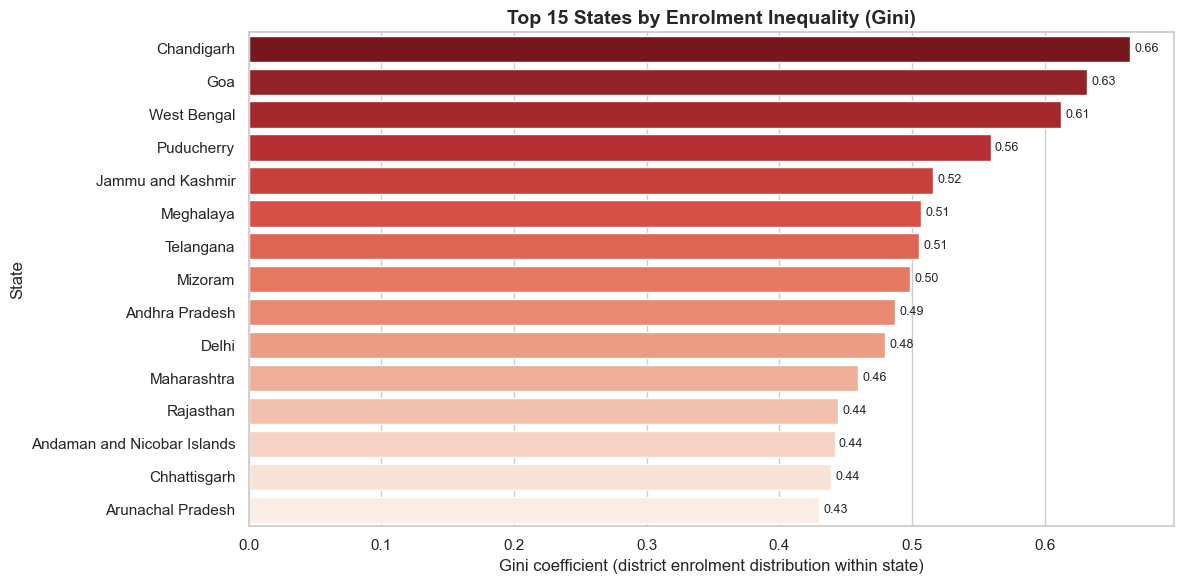

In [5]:
# 3.1 Essential Viz 1 — State-wise Gini ranking
top_n = 15
plot_df = state_ineq.dropna(subset=['gini_enroll']).sort_values('gini_enroll', ascending=False).head(top_n)

plt.figure(figsize=(12, 6))
ax = sns.barplot(data=plot_df, x='gini_enroll', y='state', palette='Reds_r')
ax.set_title(f'Top {top_n} States by Enrolment Inequality (Gini)', fontsize=14, fontweight='bold')
ax.set_xlabel('Gini coefficient (district enrolment distribution within state)')
ax.set_ylabel('State')
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', padding=3, fontsize=9)
plt.tight_layout()
plt.show()

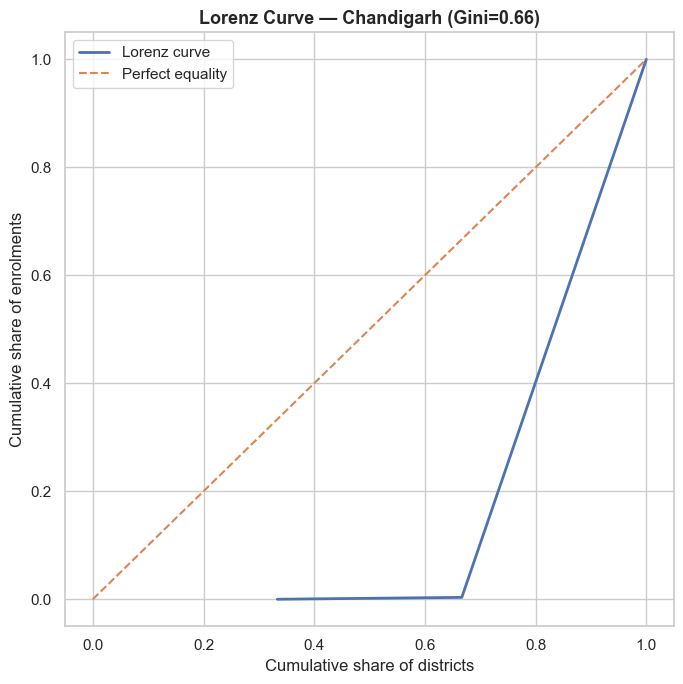

'Chandigarh'

In [6]:
# 3.2 Essential Viz 2 — Lorenz curve for the most unequal state
most_unequal_state = state_ineq.sort_values('gini_enroll', ascending=False).iloc[0]['state']
vals = asis.loc[asis['state'] == most_unequal_state, 'total_enrollments'].astype(float).fillna(0).values
vals = np.clip(vals, 0, None)
vals_sorted = np.sort(vals)
cumvals = np.cumsum(vals_sorted)
cumvals = cumvals / cumvals[-1] if cumvals[-1] > 0 else cumvals
pop = np.arange(1, len(vals_sorted) + 1) / len(vals_sorted)

g = gini_coefficient(vals)

plt.figure(figsize=(7, 7))
plt.plot(pop, cumvals, label='Lorenz curve', linewidth=2)
plt.plot([0, 1], [0, 1], '--', label='Perfect equality')
plt.title(f'Lorenz Curve — {most_unequal_state} (Gini={g:.2f})', fontsize=13, fontweight='bold')
plt.xlabel('Cumulative share of districts')
plt.ylabel('Cumulative share of enrolments')
plt.legend()
plt.tight_layout()
plt.show()

most_unequal_state

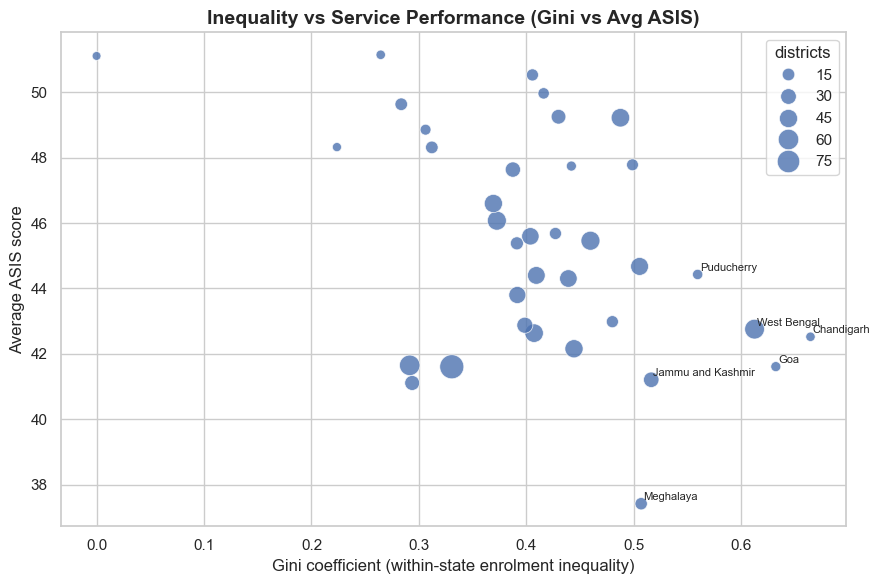

In [7]:
# 3.3 Essential Viz 3 — Gini vs Avg ASIS
viz_df = state_ineq.dropna(subset=['gini_enroll', 'avg_ASIS']).copy()

plt.figure(figsize=(9, 6))
ax = sns.scatterplot(data=viz_df, x='gini_enroll', y='avg_ASIS', size='districts', sizes=(40, 300), alpha=0.8)
ax.set_title('Inequality vs Service Performance (Gini vs Avg ASIS)', fontsize=14, fontweight='bold')
ax.set_xlabel('Gini coefficient (within-state enrolment inequality)')
ax.set_ylabel('Average ASIS score')

# Label a few notable outliers (highest Gini)
label_df = viz_df.sort_values('gini_enroll', ascending=False).head(6)
for _, r in label_df.iterrows():
    ax.text(r['gini_enroll'] + 0.002, r['avg_ASIS'] + 0.1, r['state'], fontsize=8)

plt.tight_layout()
plt.show()

C:\Users\mkgaj\AppData\Local\Temp\ipykernel_14688\1421549006.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=kpi_df, x='top20_share', y='state', palette='Blues_r')


AttributeError: 'NoneType' object has no attribute 'get_bbox'

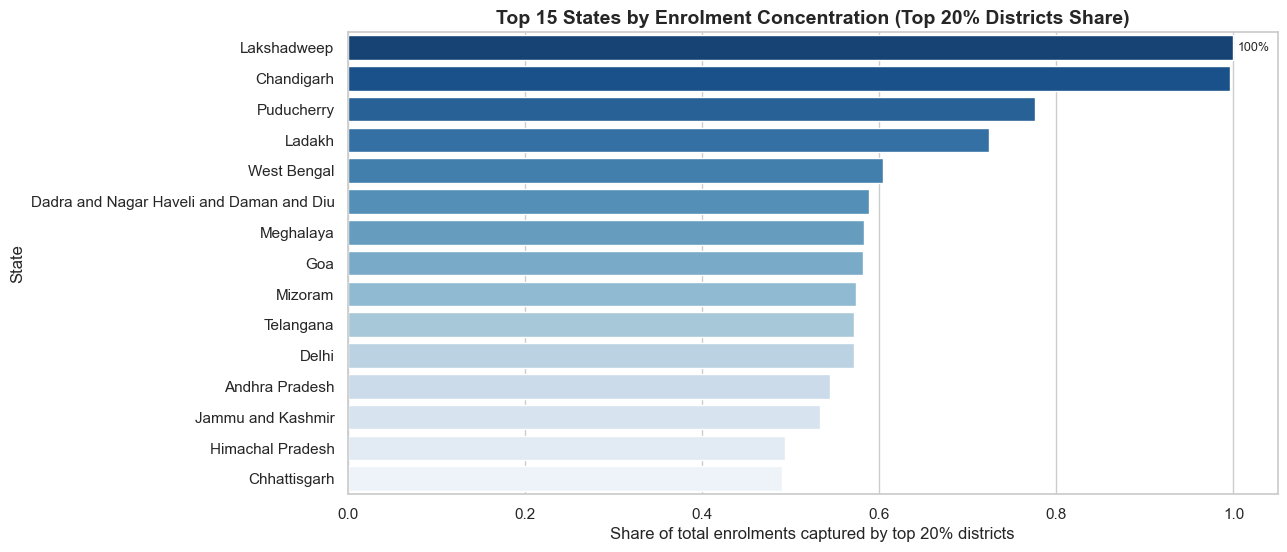

In [8]:
# 3.4 Essential KPI — Top-20% district share (interpretable inequality)
kpi_df = state_ineq.dropna(subset=['top20_share', 'gini_enroll']).sort_values('top20_share', ascending=False).head(15)

plt.figure(figsize=(12, 6))
ax = sns.barplot(data=kpi_df, x='top20_share', y='state', palette='Blues_r')
ax.set_title('Top 15 States by Enrolment Concentration (Top 20% Districts Share)', fontsize=14, fontweight='bold')
ax.set_xlabel('Share of total enrolments captured by top 20% districts')
ax.set_ylabel('State')
for container in ax.containers:
    ax.bar_label(container, fmt='%.0f%%', labels=[f'{v*100:.0f}%' for v in kpi_df['top20_share']], padding=3, fontsize=9)
plt.tight_layout()
plt.show()

In [ ]:
# Helpful tables for the write-up
display_cols = ['state', 'districts', 'gini_enroll', 'top20_share', 'top10_share', 'avg_ASIS', 'total_enrollments']
summary = state_ineq[display_cols].dropna(subset=['gini_enroll']).sort_values('gini_enroll', ascending=False)

print('Top 10 high-inequality states:')
display(summary.head(10))

print('Bottom 10 low-inequality states:')
display(summary.tail(10))

## 4) Full write-up (3–4 pages)

### 4.1 Why this is a real societal problem
Aadhaar is an access-layer for essential services (subsidies, banking, education, welfare). If enrolment capacity is concentrated in a few districts, residents of low-coverage districts face higher travel cost, longer wait times, and delayed access to government schemes. This is not just an operational issue: it directly translates into **exclusion risk** for rural, tribal, border, and low-infrastructure communities.

### 4.2 What the data shows (evidence-based)
We quantify inequality using two complementary signals computed from district totals inside each state:
- **Gini coefficient (within-state)**: $0$ means perfect equality; $1$ means extreme concentration.
- **Top-20% district share**: what fraction of enrolments are captured by the top 20% districts in that state.

When Gini is high, the Lorenz curve bends strongly away from the equality line, meaning a small share of districts contributes a disproportionately large share of enrolments. In practice, this indicates that enrolment opportunity is being delivered unevenly across districts.

### 4.3 Likely root causes (interpretable, actionable)
The inequality signal can arise from a mix of demand and supply factors:
1. **Urban-centric infrastructure**: centers and operators are denser in metropolitan districts.
2. **Profit/throughput incentives**: private operators prefer high-demand urban zones.
3. **Connectivity & access barriers**: poor road networks and limited transport raise friction for rural citizens.
4. **Campaign targeting bias**: campaigns may focus on high-visibility areas, amplifying concentration.
5. **Population vs capacity mismatch**: resources allocated using population density alone can ignore hard-to-reach populations.

### 4.4 Why Gini is better than only using totals
Using only total state enrolment can be misleading: a state can have high total enrolments but still be inequitable if activity is concentrated in a few districts. Gini focuses on **distribution fairness**, making it suitable for policy and equity decisions.

### 4.5 Risks and impact if not addressed
- **Service exclusion**: low-coverage districts fall further behind, widening the urban–rural gap.
- **Delayed benefit delivery**: beneficiaries without Aadhaar face friction in accessing DBT-linked schemes.
- **Crowding externalities**: high-volume districts experience overcrowding, lowering citizen experience and increasing error rates.
- **Fraud surface**: persistently low-oversight or low-activity areas can become targets for suspicious operational patterns.

### 4.6 Solution framework (how to fix it)
We propose a 4-part equity strategy:

**(A) Equity-based resource allocation**
- Allocate operators/devices using a blended score: population need + distance/access constraints + current enrolment gap.
- Prioritize the bottom-quintile districts in high-Gini states for immediate intervention.

**(B) District-level targets and accountability**
- Set district targets for *new enrolments* and *updates*; targets should be realistic and season-aware.
- Track monthly improvement: Gini reduction, reduction in bottom-decile gap, and improved active-days coverage.

**(C) Operational redistribution and mobile coverage**
- Rebalance staff and machines from saturated districts (where marginal benefit is lower) to underserved districts.
- Use **mobile enrolment units** and scheduled camps for remote blocks to reduce travel friction.

**(D) Monitoring dashboard and early warning**
- Weekly dashboard: state Gini, top-20% share, bottom 10% districts by coverage, and trend lines.
- Alerts when inequality worsens (e.g., Gini +0.05 month-over-month).

### 4.7 Implementation plan (practical steps)
**Phase 1 (0–4 weeks): Baseline + target selection**
- Compute state-wise Gini and top-20% shares monthly.
- Identify high-inequality states and select bottom-quintile districts for intervention.

**Phase 2 (1–3 months): Rapid interventions**
- Launch mobile camps in bottom-quintile districts.
- Reallocate spare capacity from saturated districts (staff rotation, extra devices).

**Phase 3 (3–6 months): System improvements**
- Move to demand-aware scheduling and district accountability reviews.
- Institutionalize the dashboard and publish district performance benchmarks.

### 4.8 KPIs to track (what success looks like)
- **Gini coefficient** falls by 0.10–0.15 in the selected states over 6 months.
- **Top-20% share** decreases (less concentration).
- **Bottom-quintile district enrolments** grow faster than the state median.
- **Active-days coverage** increases in underserved districts.
- **Avg ASIS** improves in low-coverage districts (service performance uplift).

### 4.9 Limitations and next data to add
- District totals do not directly measure *distance to center*; adding geospatial center-location data would strengthen causal attribution.
- Adding **population denominators** (district population) would enable true coverage rates instead of raw totals.
- Adding center capacity and staffing data would help optimize redistribution more precisely.